# Transfer learning with Tensorflow Part 2: Fine Tuning 


In [1]:
! nvidia-smi 

Thu Oct  7 23:55:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# In the previous notebooks we have written a lot of helper function , lets import them 

Its always better to import the helper function.

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-10-07 23:55:14--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-10-07 23:55:14 (46.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback,plot_loss_curves,unzip_data,walk_through_dir

### Now lets get some data 

This time we are going to see how we can us the pretrained models wihtin 'tf.kera.applications' and apply them to our own problem.
https://www.tensorflow.org/api_docs/python/tf/keras/applications?hl=en

In [4]:
# get 10 % of the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2021-10-07 23:55:17--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.15.128, 173.194.76.128, 66.102.1.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.15.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  57.7MB/s    in 2.8s    

2021-10-07 23:55:20 (57.7 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
unzip_data("10_food_classes_10_percent.zip")

In [6]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/c

In [7]:
# lets create the training and testing directory 
import tensorflow as tf


train_dir='/content/10_food_classes_10_percent/train'
test_dir='/content/10_food_classes_10_percent/test'

# For image pre-processing we were using ImagedataGenerator and now we are going to use image_dataset_from directory
IMG_SIZE=(224,224)
BATCH_SIZE=32
train_data_10_percent=tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                          image_size=IMG_SIZE,
                                                                          label_mode='categorical',
                                                                          batch_size=BATCH_SIZE)
test_data=tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                              label_mode='categorical',
                                                              image_size=IMG_SIZE,
                                                              batch_size=BATCH_SIZE)




Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [9]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
for images,labels in train_data_10_percent.take(1):
  print(images,labels)

tf.Tensor(
[[[[2.54000000e+02 2.54000000e+02 2.54000000e+02]
   [2.54000000e+02 2.54000000e+02 2.54000000e+02]
   [2.54000000e+02 2.54000000e+02 2.54000000e+02]
   ...
   [1.69495239e+02 1.48505341e+02 1.00500259e+02]
   [1.42101303e+02 1.07412453e+02 6.87441559e+01]
   [7.09336472e+01 2.59335766e+01 4.59158778e-01]]

  [[2.54000000e+02 2.54000000e+02 2.54000000e+02]
   [2.54000000e+02 2.54000000e+02 2.54000000e+02]
   [2.54000000e+02 2.54000000e+02 2.54000000e+02]
   ...
   [1.64882782e+02 1.44852097e+02 9.17245178e+01]
   [1.69147629e+02 1.38071045e+02 9.22088776e+01]
   [8.07639160e+01 4.24067039e+01 1.28105288e+01]]

  [[2.54000000e+02 2.54000000e+02 2.54000000e+02]
   [2.54000000e+02 2.54000000e+02 2.54000000e+02]
   [2.54000000e+02 2.54000000e+02 2.54000000e+02]
   ...
   [1.62055908e+02 1.45504883e+02 8.49589005e+01]
   [2.00040543e+02 1.76341492e+02 1.21310966e+02]
   [1.08978310e+02 7.89118881e+01 3.41518936e+01]]

  ...

  [[2.53785706e+02 2.54785706e+02 2.23785706e+02]
   [2

# Sequential api model vs the fucntional api model

The sequential API is a straight forward , it rus our layers ina sequential order 

But the fucntional API gives us a lot more flexibility with our models

In [11]:
# 1. create a base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. freeze the base model (so the underlying weights do no change)
base_model.trainable=False


# 3. create inputs into our models 
inputs=tf.keras.layers.Input(shape=(224,224,3),name='input_layer')

# 4. If using Resnet50v2, we will need to normalise inputs 

#x= tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)


# 5. Pass the inputs to the base_model 
x=base_model(inputs)
print(f"shape after passing the inputs through base model:{x.shape}")

# 6. average pool the outputs of the base model input layer 
x= tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
print(f" shape after GlobalAveragePooling 2D :{x.shape}")

#7. create the output activation layer 
outputs= tf.keras.layers.Dense(10,activation="softmax",name="output_layer")(x)

#8. Combine the inputs with the outputs into a model 
model_0=tf.keras.Model(inputs,outputs)

# 9.compile the model 

model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit the model and save its history 
history_10_percent=model_0.fit(train_data_10_percent,
                               epochs=5,
                               steps_per_epoch=len(train_data_10_percent),
                               validation_data=test_data,
                               validation_steps=int(0.25*len(test_data)),
                               callbacks=[create_tensorboard_callback("transfer_learning","10_percent_feature_exrtaction")])

# 10. fit the model





16719872/16705208 [==============================] - 1s 0us/step
shape after passing the inputs through base model:(None, 7, 7, 1280)
 shape after GlobalAveragePooling 2D :(None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_exrtaction/20211007-235533
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 44s 379ms/step - loss: 1.9493 - accuracy: 0.3707 - val_loss: 1.3821 - val_accuracy: 0.7105
Epoch 2/5
24/24 [==============================] - 9s 356ms/step - loss: 1.1658 - accuracy: 0.7427 - val_loss: 0.9286 - val_accuracy: 0.8076
Epoch 3/5
24/24 [==============================] - 9s 357ms/step - loss: 0.8493 - accuracy: 0.8107 - val_loss: 0.7397 - val_accuracy: 0.8289
Epoch 4/5
24/24 [==============================] - 7s 263ms/step - loss: 0.6911 - accuracy: 0.8387 - val_loss: 0.6614 - val_accuracy: 0.8322
Epoch 5/5
24/24 [==============================] - 7s 261ms/step - loss: 0.6063 - accuracy: 0.8587 - val_loss: 0.6048 - val_accuracy: 0.8388


In [12]:
# Evaluate on full test dataset 

model_0.evaluate(test_data)

79/79 [==============================] - 11s 134ms/step - loss: 0.6098 - accuracy: 0.8384


[0.6097550392150879, 0.8384000062942505]

In [13]:
# Check the layuers in the base model 
# The efficient net model has a rescaling layer so there is no need of any extra layer 

for layer_number , layer in enumerate(base_model.layers):
  print(layer_number,layer.name)


0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [14]:
# how to get the summary of the model ?

base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

In [15]:
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


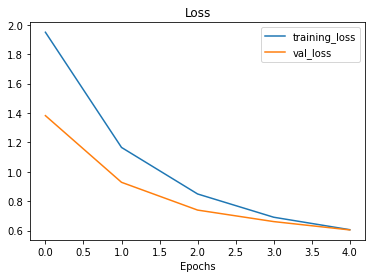

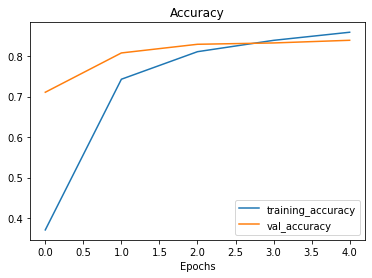

In [16]:
# Lets check the models loss cureves 
plot_loss_curves(history_10_percent)

# Getting a feture vector from a trained model 

Lets demonstrate the global average pooling 2D layer .

We have tensor after ourmodel goes through the base model of shaep (None,7,7,1280).

but then whn it pases through the global average pooling 2D it turns into (None ,1280).


Now lets tweak rthe input to (1,4,4,3) and then pass it to Globalaveragepooling 2d


In [17]:
# define the input shape 
input_shape =(1,4,4,3)

# create a random tensor 
tf.random.set_seed(42)
input_tensor=tf.random.normal(input_shape)

print(f"Random input tensor {input_tensor}")

# lets pass it through global average pooling layer 
global_average_pooled_tensor=tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"Global average pooled tensor {global_average_pooled_tensor}")


# check the shape of the tensors 
print(f"shape of the input tensor {input_tensor.shape}")
print(f"shape of the pooled tensor {global_average_pooled_tensor.shape}")

Random input tensor [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]
Global average pooled tensor [[-0.09368646 -0.45840448 -0.2885598 ]]
shape of the input tensor (1, 4, 4, 3)
shape of the pooled tensor (1, 3)


In [18]:
# the gobalaveragepool layer can be replicated 
tf.reduce_mean(input_tensor,axis=[1,2])


<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [19]:
# lets repeat the same using the globalmaxpool2d 
global_max_pooled_tensor=tf.keras.layers.GlobalMaxPool2D()(input_tensor)

print(f"Global max pooled tensor {global_max_pooled_tensor}")


# check the shape of the tensors 
print(f"shape of the input tensor {input_tensor.shape}")
print(f"shape of the pooled tensor {global_max_pooled_tensor.shape}")


Global max pooled tensor [[0.9058464 1.1603122 1.6994323]]
shape of the input tensor (1, 4, 4, 3)
shape of the pooled tensor (1, 3)


In [20]:
tf.reduce_max(input_tensor,axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

## Running a series of transfer learning experiments 

we've seen the incredible results the transfer learning can get with 10% , but lets check it out how the model is going to behave for 1% of the training data.<br>

1. 'model_1' -use the featuer extraction transferlearning with 1% if the training data with data augumentation.
2. 'model_2'- use feature extraction transfer learning with 10 % of the training data with data augumentation. 
3. 'model_3'- use fine-tuning transfer learning on 10% of the training data with data augumentation. 
4. 'model_4'-use fine-tuning transfer learning on 1% of the training data with data augumentation.


Note: throught the experiment the same test dataset is used to keep the consistency of the experiment. 



In [21]:
# Download and unzip dtaa for 1%
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2021-10-07 23:57:07--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.5.128, 64.233.184.128, 74.125.71.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.5.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  69.0MB/s    in 1.8s    

2021-10-07 23:57:10 (69.0 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [22]:
# create trainig and test data
train_dir_1_percent="10_food_classes_1_percent/train"
test_dir="10_food_classes_10_percent/test"

In [23]:
# how many images am i working with ?
walk_through_dir("10_food_classes_1_percent") 

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There a

In [24]:
# Setup data loaders 
IMG_SIZE=(224,224)


train_data_1_percent=tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                         image_size=IMG_SIZE,
                                                                         label_mode='categorical',
                                                                         batch_size=32)

test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              label_mode='categorical',
                                                              image_size=IMG_SIZE,
                                                              batch_size=32)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


# Data augumentation 
Instead of making data augumentation as a separate step, we can build the data augumetnation as a part of the layer. Have to refer the documentation to get a better understanding of the preprocessing feature 

In [25]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers 
from tensorflow.keras.layers.experimental import preprocessing

# create data augumentation stage with horizontal flipping , rotations and zooms 

data_augumentation=keras.Sequential([
                                     preprocessing.RandomFlip("horizontal"),
                                     preprocessing.RandomRotation(0.2),
                                     preprocessing.RandomZoom(0.2),
                                     preprocessing.RandomHeight(0.2),
                                     preprocessing.RandomWidth(0.2),
                                     #preprocessing.Rescale(1/255.)
],name='data_augumentation')

the acutal image that is observed in the trainign data set 
the augumented image that is observed in the training data set 


(-0.5, 527.5, 413.5, -0.5)

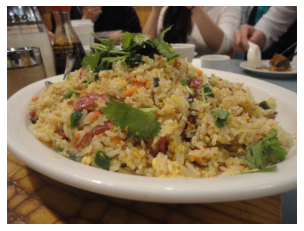

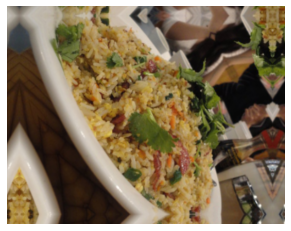

In [26]:
# Lets visualise the data augumentation 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random 

target_class=random.choice(train_data_1_percent.class_names)
target_dir="10_food_classes_1_percent/train/"+target_class
random_image=random.choice(os.listdir(target_dir))
random_image_path=target_dir+'/'+random_image 

# Read the image 
print(f"the acutal image that is observed in the trainign data set ")
img=mpimg.imread(random_image_path)
#print(img)
plt.imshow(img)
plt.axis(False)

# Lets read the augumented data 
plt.figure()
print(f"the augumented image that is observed in the training data set ")
augumented_img=data_augumentation(img)
plt.imshow(augumented_img/255.)
plt.axis(False)


# model 1:feature extraction transfer learning on 1% of the data with data augumentation


In [27]:
# setup the input shape and base mode , freezig the base model layers 
input_shape=(224,224,3)
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False 

# create input layer 
inputs =layers.Input(shape=input_shape,name="input_layer")

# Add in data augumentation Sequential model as a layer 
x=data_augumentation(inputs)

# Lets give the input to the base model
x=base_model(x,training=False)

# Pool the output features of the base model
x=layers.GlobalMaxPooling2D()(x)

# Lets create a dense layer on top of the model 
outputs=layers.Dense(10,activation='softmax',name='output_layer')(x)

# make a model using the inputs and the outputs
model_1=keras.Model(inputs,outputs)


# Compile the model 
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])


# Fit the model 
history_1_percent= model_1.fit(train_data_1_percent,
                               steps_per_epoch=len(train_data_1_percent),
                               validation_data=test_data,
                               validation_steps=(.25*len(test_data)),
                               epochs=5,
                               callbacks =[create_tensorboard_callback(dir_name='transfer_learning',
                                                                       experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20211007-235715
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


3/3 [==============================] - 14s 3s/step - loss: 5.8764 - accuracy: 0.0714 - val_loss: 5.5176 - val_accuracy: 0.1031
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 5.1668 - accuracy: 0.1571 - val_loss: 4.6038 - val_accuracy: 0.1187
Epoch 3/5
3/3 [==============================] - 5s 2s/step - loss: 3.8435 - accuracy: 0.1857 - val_loss: 3.7702 - val_accuracy: 0.1859
Epoch 4/5
3/3 [==============================] - 7s 3s/step - loss: 3.4115 - accuracy: 0.2143 - val_loss: 3.8267 - val_accuracy: 0.2109
Epoch 5/5
3/3 [==============================] - 5s 2s/step - loss: 2.6966 - accuracy: 0.2429 - val_loss: 3.4850 - val_accuracy: 0.2375


In [28]:
# model 1 summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augumentation (Sequenti (None, None, 3)           0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [29]:
# Evaluate on full test dataset 
results_1_percent_data_sug=model_1.evaluate(test_data)
results_1_percent_data_sug

79/79 [==============================] - 11s 129ms/step - loss: 3.4998 - accuracy: 0.2380


[3.4997997283935547, 0.23800000548362732]

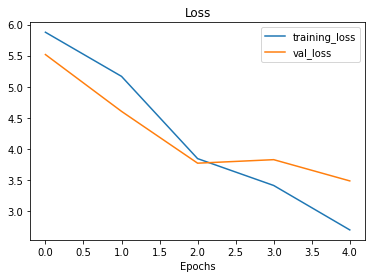

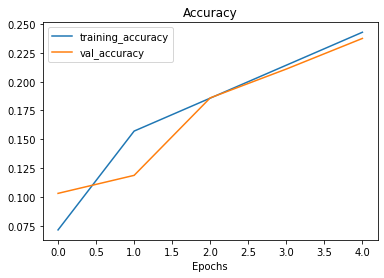

In [30]:
# how do the loss curve look 
plot_loss_curves(history_1_percent)

In [31]:
## Model 2 : same as model 1 but with the 10 % data 
input_shape= (224,224,3)

base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False



# Input layer 
inputs=layers.Input(shape=input_shape,name='input_layer')

# Data Augumentation 
x=data_augumentation(inputs)

# Feed the input layer to the base model layer
x= base_model(x,training=False)

# Global average pooling layer 
x=layers.GlobalAveragePooling2D()(x)

# Dense layer 
outputs=layers.Dense(10,activation='softmax')(x)

# model 
model_2=keras.Model(inputs,outputs)

# compile model
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])



In [32]:
#model summary
model_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augumentation (Sequenti (None, None, 3)           0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [33]:
##### creating a model checkpoint callback 
checkpoint_path="ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# create a model checkpoint callback that saves the model's weigths only
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                       save_weights_only=True,
                                                       save_best_only=False,
                                                       save_freq='epoch',
                                                       verbose=1)


In [34]:
# Fit the model 
history_10_percent=model_2.fit(train_data_10_percent,
                               steps_per_epoch=len(train_data_10_percent),
                               validation_data =test_data,
                               validation_steps=(.25*len(test_data)),
                               epochs=5,
                               callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                      experiment_name='10_percent_data_aug'),
                                          checkpoint_callback]) 

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20211007-235827
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 26s 808ms/step - loss: 2.0154 - accuracy: 0.3387 - val_loss: 1.5054 - val_accuracy: 0.6672

Epoch 00001: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 2/5
24/24 [==============================] - 15s 609ms/step - loss: 1.3601 - accuracy: 0.6747 - val_loss: 1.0692 - val_accuracy: 0.7781

Epoch 00002: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 3/5
24/24 [==============================] - 17s 688ms/step - loss: 1.0908 - accuracy: 0.7373 - val_loss: 0.8464 - val_accuracy: 0.8156

Epoch 00003: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 4/5
24/24 [==============================] - 17s 691ms/step - loss: 0.8949 - accuracy: 0.7867 - val_loss: 0.7211 - val_accuracy: 0.8234

Epoch 00004: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 5/5
24/24 [==============================] - 14s 559ms/step - loss: 0.8037 - accuracy: 0.7787 - val_

In [35]:
# lets evaluate the model 2
results_10_percent_data_aug=model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 11s 130ms/step - loss: 0.6949 - accuracy: 0.8080


[0.6949167847633362, 0.8080000281333923]

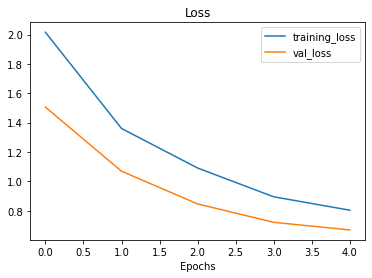

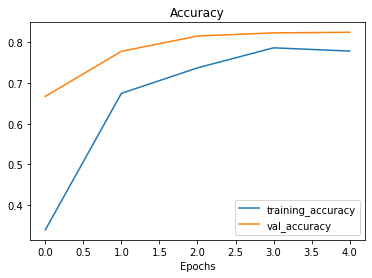

In [36]:
plot_loss_curves(history_10_percent)

# Load in the weigths from the checkpoint and compare it to the actual model 


In [37]:
model_2.load_weights(checkpoint_path)

In [ ]:
loaded_weights_model_results=model_2.evaluate(test_data)

79/79 [==============================] - 11s 131ms/step - loss: 0.5518 - accuracy: 0.8380


In [ ]:
# If the results from the previous model is the same as the loaded results then we can be sure that the callback works 
 

### Model 3: Fine-tunining an existing model on 10 % of the data 

> **Note:** Fine-tuning usually works best after training a feature extraction model for a few epochs with large amounts of custom data. 

In [38]:
# Layers inloaded model 
model_2.layers

In [39]:
# Are these layers trainable ?
for layer in model_2.layers:
  print(layer,layer.trainable)


<keras.engine.input_layer.InputLayer object at 0x7f9e116d5f90> True
<keras.engine.sequential.Sequential object at 0x7f9ee289bbd0> True
<keras.engine.functional.Functional object at 0x7f9e122c1250> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f9e12238990> True
<keras.layers.core.Dense object at 0x7f9e122b71d0> True


In [43]:
for i,layer in enumerate(model_2.layers[2].layers):
  print(i,layer.name,layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [44]:
# how many trainable variables are in our base model ?
print(len(model_2.layers[2].trainable_variables))

0


In [45]:
# To begin fine-tuning , let's start by setting the last 10 layers of our base_model.trainable=True
base_model.trainable=True 

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable=False

# Recompile (we have to recompile our model every time we make a change)
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [47]:
# Check which layers are tunable (trainable)
for layer_number,layer in enumerate(model_2.layers[2].layers):
  print(layer_number,layer.name,layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [46]:
for layer in base_model.layers[:-10]:
  print(layer.name)

input_3
rescaling_2
normalization_2
stem_conv_pad
stem_conv
stem_bn
stem_activation
block1a_dwconv
block1a_bn
block1a_activation
block1a_se_squeeze
block1a_se_reshape
block1a_se_reduce
block1a_se_expand
block1a_se_excite
block1a_project_conv
block1a_project_bn
block2a_expand_conv
block2a_expand_bn
block2a_expand_activation
block2a_dwconv_pad
block2a_dwconv
block2a_bn
block2a_activation
block2a_se_squeeze
block2a_se_reshape
block2a_se_reduce
block2a_se_expand
block2a_se_excite
block2a_project_conv
block2a_project_bn
block2b_expand_conv
block2b_expand_bn
block2b_expand_activation
block2b_dwconv
block2b_bn
block2b_activation
block2b_se_squeeze
block2b_se_reshape
block2b_se_reduce
block2b_se_expand
block2b_se_excite
block2b_project_conv
block2b_project_bn
block2b_drop
block2b_add
block3a_expand_conv
block3a_expand_bn
block3a_expand_activation
block3a_dwconv_pad
block3a_dwconv
block3a_bn
block3a_activation
block3a_se_squeeze
block3a_se_reshape
block3a_se_reduce
block3a_se_expand
block3a_se_

In [48]:
model_2.trainable_variables

[<tf.Variable 'block7a_se_reduce/kernel:0' shape=(1, 1, 1152, 48) dtype=float32, numpy=
 array([[[[-0.05485657,  0.07178846,  0.01534605, ..., -0.09284662,
            0.0104828 , -0.02693838],
          [-0.03157939,  0.02819107, -0.05579546, ...,  0.00487578,
            0.12001809, -0.06901816],
          [-0.07792544,  0.12601745,  0.03935236, ...,  0.03086486,
           -0.01581392,  0.1306234 ],
          ...,
          [-0.07692936,  0.19920062,  0.17471024, ...,  0.03312391,
           -0.04528928, -0.09214652],
          [ 0.01010198,  0.06855008,  0.05820991, ...,  0.00131649,
           -0.08952942, -0.00476829],
          [ 0.03583075, -0.01228165,  0.04561347, ..., -0.00822134,
           -0.07354517, -0.06507882]]]], dtype=float32)>,
 <tf.Variable 'block7a_se_reduce/bias:0' shape=(48,) dtype=float32, numpy=
 array([-0.10886215, -0.13624744, -0.15257476,  0.14799541, -0.08512902,
        -0.12059905, -0.08779966, -0.08187538, -0.06925284, -0.12518929,
        -0.0819265 ,

In [49]:
print(len(model_2.trainable_variables))

12


In [54]:
# Fine tune for another 5 epochs 
initial_epochs=5


fine_tune_epochs=initial_epochs+5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug=model_2.fit(train_data_10_percent,
                                             epochs=fine_tune_epochs,
                                             validation_data=test_data,
                                             validation_steps=0.25*len( test_data),
                                             initial_epoch=history_10_percent.epoch[-1],
                                             callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                    experiment_name="10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20211008-005706
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 13s 535ms/step - loss: 0.4043 - accuracy: 0.9013 - val_loss: 0.5057 - val_accuracy: 0.8422
Epoch 6/10
24/24 [==============================] - 13s 520ms/step - loss: 0.3814 - accuracy: 0.9120 - val_loss: 0.4839 - val_accuracy: 0.8578
Epoch 7/10
24/24 [==============================] - 14s 568ms/step - loss: 0.3768 - accuracy: 0.9120 - val_loss: 0.4880 - val_accuracy: 0.8516
Epoch 8/10
24/24 [==============================] - 12s 465ms/step - loss: 0.3589 - accuracy: 0.9280 - val_loss: 0.4851 - val_accuracy: 0.8469
Epoch 9/10
24/24 [==============================] - 12s 494ms/step - loss: 0.3462 - accuracy: 0.9107 - val_loss: 0.4672 - val_accuracy: 0.8516
Epoch 10/10
24/24 [==============================] - 14s 568ms/step - loss: 0.3321 - accuracy: 0.9253 - val_loss: 0.4680 - val_accuracy: 0.8562


In [55]:
# Evaluate the fine-tuned model (model_3 which is actually model_2 fine-tuned for another 5 epochs)
results_fine_tune_10_percent=model_2.evaluate(test_data)

79/79 [==============================] - 11s 130ms/step - loss: 0.4868 - accuracy: 0.8416


In [56]:
results_10_percent_data_aug

[0.6949167847633362, 0.8080000281333923]

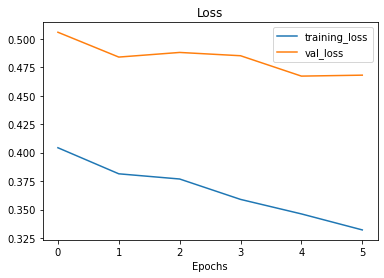

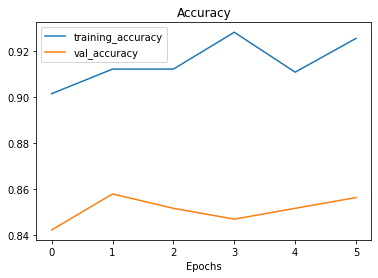

In [58]:
# check out the loss curves of our fine-tuned model
plot_loss_curves(history_fine_10_percent_data_aug)

In [66]:
# lets create a fucntion to compare training histories 
def compare_historys(original_history, new_history, inital_epochs=5):
  """
  compares two tensorflow history objects
  """

  # get original history measurements 
  acc=original_history.history['accuracy']
  loss=original_history.history ['loss']

  val_acc=original_history.history['val_accuracy']
  val_loss=original_history.history ['val_loss']

  # combine original history 
  total_acc=acc+new_history.history['accuracy']
  total_loss=loss+new_history.history['loss']

  total_val_acc=val_acc+new_history.history['val_accuracy']
  total_val_loss=val_loss+new_history.history['val_loss']

  # Make plots 
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc,label='training accuracy')
  plt.plot(total_val_acc,label='val accuracy')
  plt.plot([initial_epochs-1,inital_epochs-1],plt.ylim(),label="start fine tuning")
  plt.legend(loc="lower right")
  plt.title("training and validation accuracy")

    # Make plots 
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,2)
  plt.plot(total_loss,label='training loss')
  plt.plot(total_val_loss,label='val loss')
  plt.plot([initial_epochs-1,inital_epochs-1],plt.ylim(),label="start fine tuning")
  plt.legend(loc="lower right")
  plt.title("training and validation LOSS")





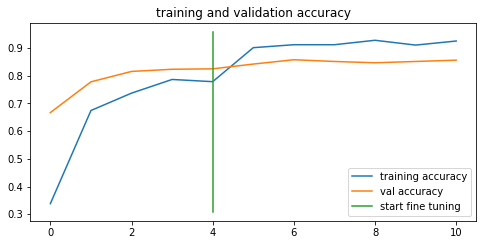

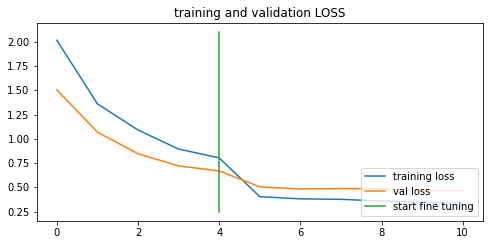

In [67]:
compare_historys(history_10_percent,history_fine_10_percent_data_aug)

# model 4 : Same as model 3 but train with the 100 % of the data 

In [68]:
# Download and unzip 100% of the data 
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2021-10-08 01:25:38--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.5.128, 74.125.133.128, 74.125.140.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.5.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   117MB/s    in 4.9s    

2021-10-08 01:25:43 (101 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [69]:
# setup the training and testing dir 
train_dir_all_data="10_food_classes_all_data/train"
test_dir="10_food_classes_all_data/test"

In [70]:
# how many images are we working on now 
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.

In [72]:
# Setup data inputs 
import tensorflow as tf

IMG_SIZE=(224,224)
train_data_10_classes_full=tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_all_data,
                                                                               image_size=IMG_SIZE,
                                                                               batch_size=32,
                                                                               label_mode='categorical')

test_data= tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                               label_mode='categorical',
                                                               image_size=IMG_SIZE)


Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test data we have used so far is the same test data that we have used in the model so far. To train the fine tuning model , we have to revert the model_2 to its feature exrtaction weights 

In [73]:
# Load weights from checkpoint, that way we can fine-tune from the ssam estage the 10 percent data model was fine-tuned from 
model_2.load_weights(checkpoint_path)

In [74]:
# lets evaluate to make sure that it has been reverted 
model_2.evaluate(test_data)

79/79 [==============================] - 11s 130ms/step - loss: 0.6949 - accuracy: 0.8080


[0.6949167251586914, 0.8080000281333923]

In [75]:
# check to see if out model_2 has been reverted back to the feature extraction results 

results_10_percent_data_aug

[0.6949167847633362, 0.8080000281333923]

In [76]:
# check which layers are tunable 
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number,layer.name, layer.trainable)

0 input_layer True
1 data_augumentation True
2 efficientnetb0 True
3 global_average_pooling2d_1 True
4 dense True


In [77]:
# lets drill into the base model and check if all the layers are trainable 

for layer_number,layer in enumerate(model_2.layers[2].layers):
  print(layer_number,layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [79]:
# From the above we can see that only the last has been set to trainable, hence now we can fit and train the model on 100% of the dataset 
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                metrics=['accuracy'])



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [83]:
# continue to train and fine-tune the model to our data (100% of training data)
initial_epochs=5
fine_tune_epochs=initial_epochs +5

history_fine_10_classes_fill=model_2.fit(train_data_10_classes_full,
                                         epochs=fine_tune_epochs,
                                         validation_data=test_data,
                                         validation_steps=int(0.25*len(test_data)),
                                         initial_epoch=history_10_percent.epoch[-1],
                                         callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                experiment_name="full_10_classes_fine_tuning")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tuning/20211008-020328
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


235/235 [==============================] - 64s 232ms/step - loss: 0.7319 - accuracy: 0.7636 - val_loss: 0.4523 - val_accuracy: 0.8503
Epoch 6/10
235/235 [==============================] - 63s 265ms/step - loss: 0.5820 - accuracy: 0.8120 - val_loss: 0.4240 - val_accuracy: 0.8684
Epoch 7/10
235/235 [==============================] - 80s 337ms/step - loss: 0.5217 - accuracy: 0.8332 - val_loss: 0.4010 - val_accuracy: 0.8783
Epoch 8/10
235/235 [==============================] - 77s 326ms/step - loss: 0.4722 - accuracy: 0.8443 - val_loss: 0.3526 - val_accuracy: 0.8799
Epoch 9/10
235/235 [==============================] - 73s 310ms/step - loss: 0.4402 - accuracy: 0.8631 - val_loss: 0.3677 - val_accuracy: 0.8783
Epoch 10/10
235/235 [==============================] - 70s 295ms/step - loss: 0.4031 - accuracy: 0.8685 - val_loss: 0.3642 - val_accuracy: 0.8980


In [84]:
# lets evaluate on all the test data 
results_fine_tune_full_data=model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 11s 129ms/step - loss: 0.3053 - accuracy: 0.8980


[0.3052532970905304, 0.8980000019073486]

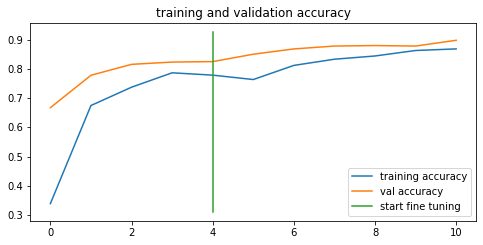

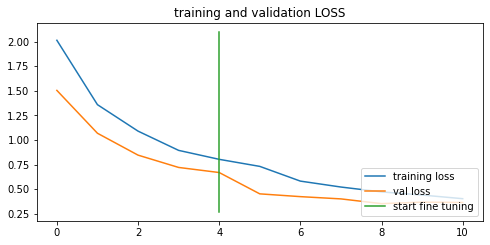

In [86]:
# how did the fine-tuning on all the data go ?
compare_historys(history_10_percent,history_fine_10_classes_fill)

In [89]:
!tensorboard dev upload --logdir ./transfer_learning \
--name "Transfer learning experiments " \
--one_shot

2021-10-08 02:15:08.710933: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-08 02:15:08.728108: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-08 02:15:08.728740: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Priv

In [90]:
# to view and delete the experiments uploaded to the tensorboard 
!tensorboard dev list

2021-10-08 02:19:11.001596: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-08 02:19:11.010762: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-08 02:19:11.011370: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
https://tensorboard.dev/experiment/esbZ9tazRJWkTVOW0qW3Qw/
	Name                 Transfer learning experiments 
	Description          [No Description]
	Id                   esbZ9tazRJWkTVOW0qW3Qw
	Created              2021-10-08 02:15:38 (3 minutes ago)
	Updated              2021-10-08 02:15:44 (3 minutes ago)
	Runs                 10
	Ta

In [ ]:
# To delete an experiment 
# !tensorboard dev delete --experiment_id 